### Importing the important libraries

In [1]:
import os
import glob
import numpy as np
from tqdm import tqdm
import itertools
import matplotlib.pyplot as plt
import pandas as pd

# Audio
import librosa
import librosa.display

# Scikit learn
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import shuffle
from sklearn.utils import class_weight

# Keras
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Convolution2D, Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.utils import to_categorical

import warnings
warnings.filterwarnings('ignore', category=FutureWarning)

2024-05-15 12:48:30.479209: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


**Creating dataframe containing all files of set c and set d**

In [2]:
dataset = []

label_replacements = {
    "20240505": "abnormal",
    "20240417": "normal"
}
for folder in ["/home/rcai/Downloads/Project_Files/input/set_c/**","/home/rcai/Downloads/Project_Files/input/set_d/**"]:
    for filename in glob.iglob(folder):
        if os.path.exists(filename):
            label = os.path.basename(filename).split("_")[0]
            label = label_replacements.get(label, label)
            duration = librosa.get_duration(filename=filename)
            # skip audio smaller than 3 secs
            if duration>=3:
                slice_size = 3
                iterations = int((duration-slice_size)/(slice_size-1))
                iterations += 1
#                 initial_offset = (duration % slice_size)/2
                initial_offset = (duration - ((iterations*(slice_size-1))+1))/2
                # if label not in ["Aunlabelledtest", "Bunlabelledtest", "artifact"]:
                for i in range(iterations):
                    offset = initial_offset + i*(slice_size-1)
                    if (label == "normal"):
                        dataset.append({
                                "filename": filename,
                                "label": "normal",
                                "offset": offset
                            })
                    else:
                        dataset.append({
                                "filename": filename,
                                "label": "abnormal",
                                "offset": offset
                            })
                        
dataset = pd.DataFrame(dataset)
dataset = shuffle(dataset, random_state=42)
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Index: 524 entries, 310 to 102
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   filename  524 non-null    object 
 1   label     524 non-null    object 
 2   offset    524 non-null    float64
dtypes: float64(1), object(2)
memory usage: 16.4+ KB


### EDA

In [3]:
dataset.head(-1)

,filename,label,offset
310,/home/rcai/Downloads/Project_Files/input/set_d...,normal,0.053156
440,/home/rcai/Downloads/Project_Files/input/set_d...,normal,0.537802
6,/home/rcai/Downloads/Project_Files/input/set_c...,abnormal,0.709646
184,/home/rcai/Downloads/Project_Files/input/set_c...,abnormal,0.434510
78,/home/rcai/Downloads/Project_Files/input/set_c...,abnormal,0.477625
...,...,...,...
20,/home/rcai/Downloads/Project_Files/input/set_c...,abnormal,0.121063
71,/home/rcai/Downloads/Project_Files/input/set_c...,abnormal,0.638406
106,/home/rcai/Downloads/Project_Files/input/set_c...,abnormal,0.079979
270,/home/rcai/Downloads/Project_Files/input/set_c...,abnormal,0.330354


In [4]:
dataset["label"].value_counts()

label
abnormal    285
normal      239
Name: count, dtype: int64

In [5]:
print(dataset["label"].value_counts().sum())

524


In [6]:
dataset.describe()

,offset
count,524.000000
mean,0.481276
std,0.289745
min,0.000687
25%,0.232703
50%,0.477620
75%,0.718232
max,0.999854


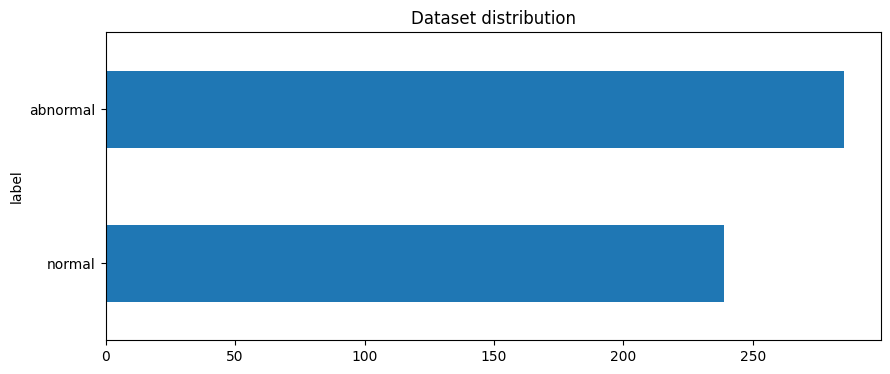

In [68]:
plt.figure(figsize=(10,4))
dataset.label.value_counts(sort=False).plot(kind='barh', title="Dataset distribution")
plt.show()

In [79]:
import plotly.offline as py
import plotly.graph_objs as go
from plotly.subplots import make_subplots
import plotly.express as px

# Calculate the duration for each audio file
dataset['duration'] = (dataset['offset'] + slice_size) - (dataset['offset'] % slice_size)

# Calculate the total duration for each label
label_durations = dataset.groupby('label')['duration'].sum().reset_index()

# Prepare the data for the pie chart
fig_pie = px.pie(values=label_durations['duration'], names=label_durations['label'],
                 title='Label distribution and total duration of the Audio dataset',
                 color_discrete_sequence = ['#0d3b66', '#81c3d7'])

# Set the plot size
fig_pie.update_layout(height=500, width=700)

# Add custom text to the pie chart slices
fig_pie.update_traces(text=['{:.2f} sec'.format(d) for d in fig_pie.data[0].values],
                      textposition='inside',
                      hoverinfo='skip',
                      textfont=dict(size=14))

# Increase the size of the title and legend text
fig_pie.update_layout(title_font=dict(size=20),
                      legend_font=dict(size=14))

# Display the pie chart
fig_pie.show()

### Splitting the dataset to create train and test data

In [8]:
train, test = train_test_split(dataset, test_size=0.2, random_state=42)

print("Train: %i" % len(train))
print("Test: %i" % len(test))

Train: 419
Test: 105


In [77]:
print("=== Training Dataset ===")
print(train.groupby('label').label.value_counts())
print("\nnumber of rows = {0}\n".format(len(train)))
print("=== Test Dataset ===")
print(test.groupby('label').label.value_counts())
print("\nnumber of rows = {0}".format(len(test)))

=== Training Dataset ===
label
abnormal    223
normal      196
Name: count, dtype: int64

number of rows = 419

=== Test Dataset ===
label
abnormal    62
normal      43
Name: count, dtype: int64

number of rows = 105


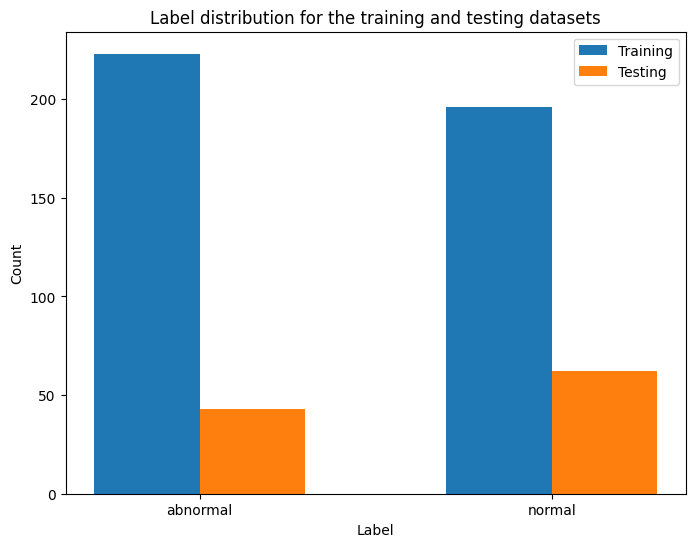

In [75]:
# Calculate the label distribution for the training and testicenterng datasets
train_distribution = train.label.value_counts(sort=False)
test_distribution = test.label.value_counts(sort=False)

# Create a new figure with a width of 8 inches and a height of 6 inches
plt.figure(figsize=(8, 6))

# Set the width of the bars in the bar plot
bar_width = 0.3

# Create the bar plot for the training dataset
train_plot = plt.bar(np.arange(len(train_distribution)), train_distribution, width=bar_width, label='Training')

# Create the bar plot for the testing dataset
test_plot = plt.bar(np.arange(len(test_distribution)) + bar_width, test_distribution, width=bar_width, label='Testing')

# Set the title and labels of the plot
plt.title('Label distribution for the training and testing datasets')
plt.xlabel('Label')
plt.ylabel('Count')

# Set the legend of the plot
plt.legend(loc='upper right')

# Set the x-axis ticks and labels
plt.xticks(np.arange(len(train_distribution)) + bar_width / 2, train_distribution.index)

# Show the plot
plt.show()

**Train Dataset EDA**

In [9]:
train.head(-1)

,filename,label,offset
145,/home/rcai/Downloads/Project_Files/input/set_c...,abnormal,0.778927
360,/home/rcai/Downloads/Project_Files/input/set_d...,normal,0.053156
41,/home/rcai/Downloads/Project_Files/input/set_c...,abnormal,0.468365
315,/home/rcai/Downloads/Project_Files/input/set_d...,normal,0.034167
488,/home/rcai/Downloads/Project_Files/input/set_d...,normal,0.478302
...,...,...,...
505,/home/rcai/Downloads/Project_Files/input/set_d...,normal,0.537802
245,/home/rcai/Downloads/Project_Files/input/set_c...,abnormal,0.297875
69,/home/rcai/Downloads/Project_Files/input/set_c...,abnormal,0.566448
321,/home/rcai/Downloads/Project_Files/input/set_d...,normal,0.690177


In [123]:
# Calculate the duration for each audio file
train['duration'] = (train['offset'] + slice_size) - (train['offset'] % slice_size)

# Calculate the total duration for each label
label_durations = train.groupby('label')['duration'].sum().reset_index()

# Prepare the data for the pie chart
fig_pie = px.pie(values=label_durations['duration'], names=label_durations['label'],
                 title='Label distribution and total duration of the Training Audio dataset',
                 color_discrete_sequence = ['#445e93', '#7eb2dd'],
                 hole = 0.6)

# Set the plot size
fig_pie.update_layout(height=500, width=700)

# Add custom text to the pie chart slices
fig_pie.update_traces(text=['{:.2f} sec'.format(d) for d in fig_pie.data[0].values],
                      textposition='inside',
                      hoverinfo='skip',
                      textfont=dict(size=14))

# Increase the size of the title and legend text
fig_pie.update_layout(title_font=dict(size=20),
                      legend_font=dict(size=14))

# Display the pie chart
fig_pie.show()

**Test Dataset EDA**

In [11]:
test.head(-1)

,filename,label,offset
354,/home/rcai/Downloads/Project_Files/input/set_d...,normal,0.708490
389,/home/rcai/Downloads/Project_Files/input/set_d...,normal,0.753292
523,/home/rcai/Downloads/Project_Files/input/set_d...,normal,0.047260
185,/home/rcai/Downloads/Project_Files/input/set_c...,abnormal,0.207458
247,/home/rcai/Downloads/Project_Files/input/set_c...,abnormal,0.390917
...,...,...,...
416,/home/rcai/Downloads/Project_Files/input/set_d...,normal,0.252781
328,/home/rcai/Downloads/Project_Files/input/set_d...,normal,0.142635
483,/home/rcai/Downloads/Project_Files/input/set_d...,normal,0.437896
511,/home/rcai/Downloads/Project_Files/input/set_d...,normal,0.206052


In [124]:
# Calculate the duration for each audio file
test['duration'] = (test['offset'] + slice_size) - (test['offset'] % slice_size)

# Calculate the total duration for each label
label_durations = test.groupby('label')['duration'].sum().reset_index()

# Prepare the data for the pie chart
fig_pie = px.pie(values=label_durations['duration'], names=label_durations['label'],
                 title='Label distribution and total duration of the Testing Audio dataset',
                 color_discrete_sequence = ['#218380', '#73d2de'],
                 hole = 0.6)

# Set the plot size
fig_pie.update_layout(height=500, width=700)

# Add custom text to the pie chart slices
fig_pie.update_traces(text=['{:.2f} sec'.format(d) for d in fig_pie.data[0].values],
                      textposition='inside',
                      hoverinfo='skip',
                      textfont=dict(size=14))

# Increase the size of the title and legend text
fig_pie.update_layout(title_font=dict(size=20),
                      legend_font=dict(size=14))

# Display the pie chart
fig_pie.show()

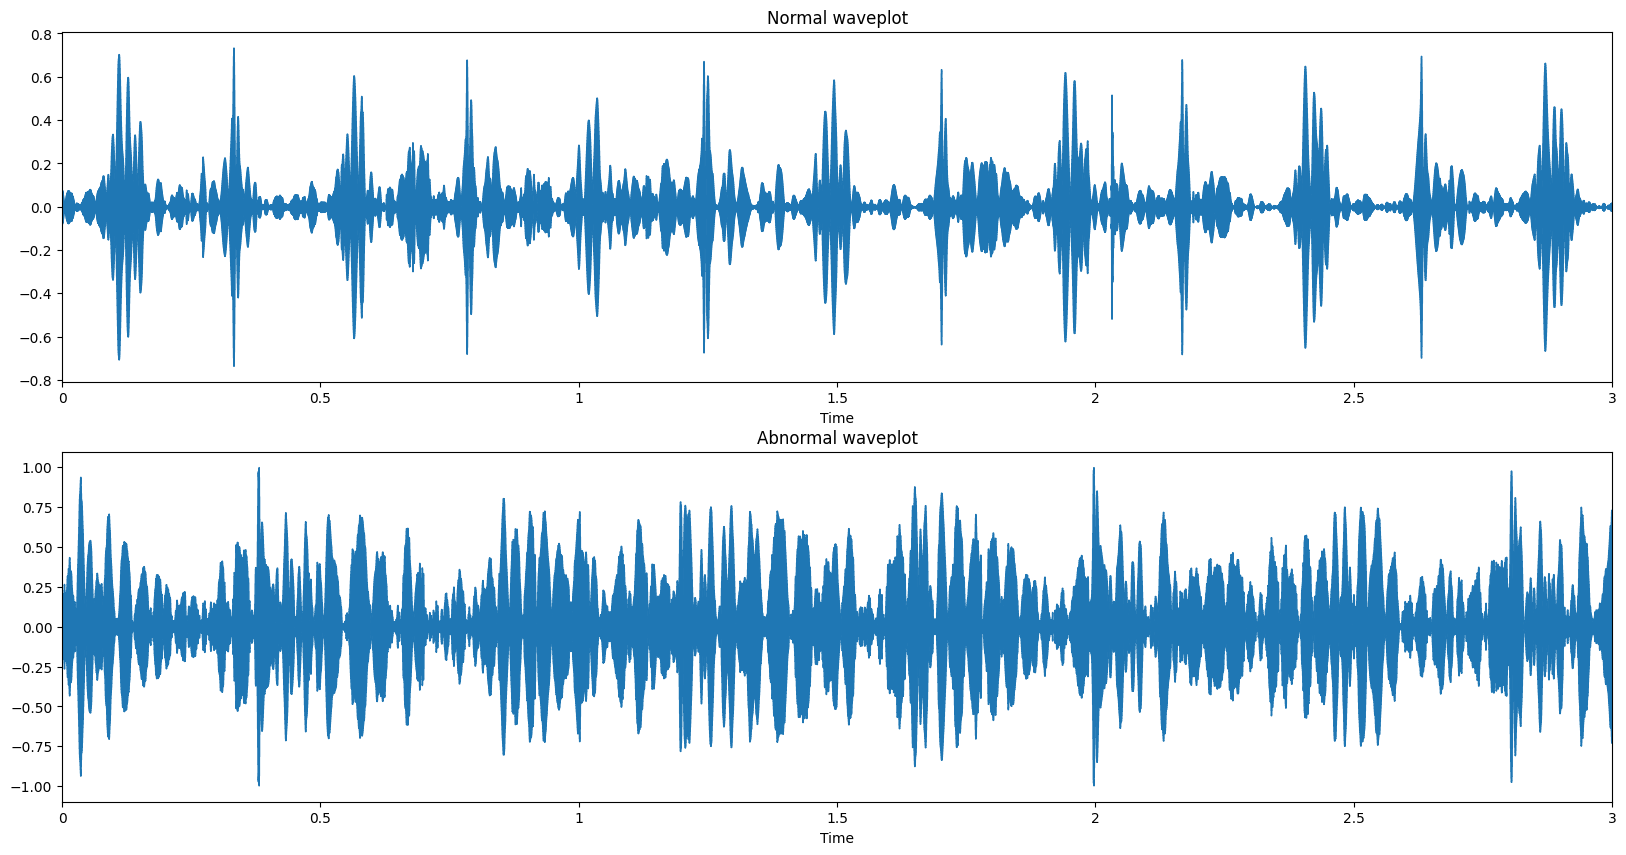

In [47]:
plt.figure(figsize=(20,10))

# Load normal audio data
normal_y, normal_sr = librosa.load(dataset[dataset.label == 'normal'].filename.iloc[33], duration=10)  # Increase duration for more detailed waveform

# Plot normal waveplot
plt.subplot(2, 1, 1)
plt.title("Normal waveplot")
librosa.display.waveshow(normal_y, sr=normal_sr)
plt.xlim(0, 3)  # Adjust x-axis limit

# Load abnormal audio data
abnormal_y, abnormal_sr = librosa.load(dataset[dataset.label == 'abnormal'].filename.iloc[33], duration=10)  # Increase duration for more detailed waveform

# Plot abnormal waveplot
plt.subplot(2, 1, 2)
plt.title("Abnormal waveplot")
librosa.display.waveshow(abnormal_y, sr=abnormal_sr)
plt.xlim(0, 3)  # Adjust x-axis limit

plt.show()

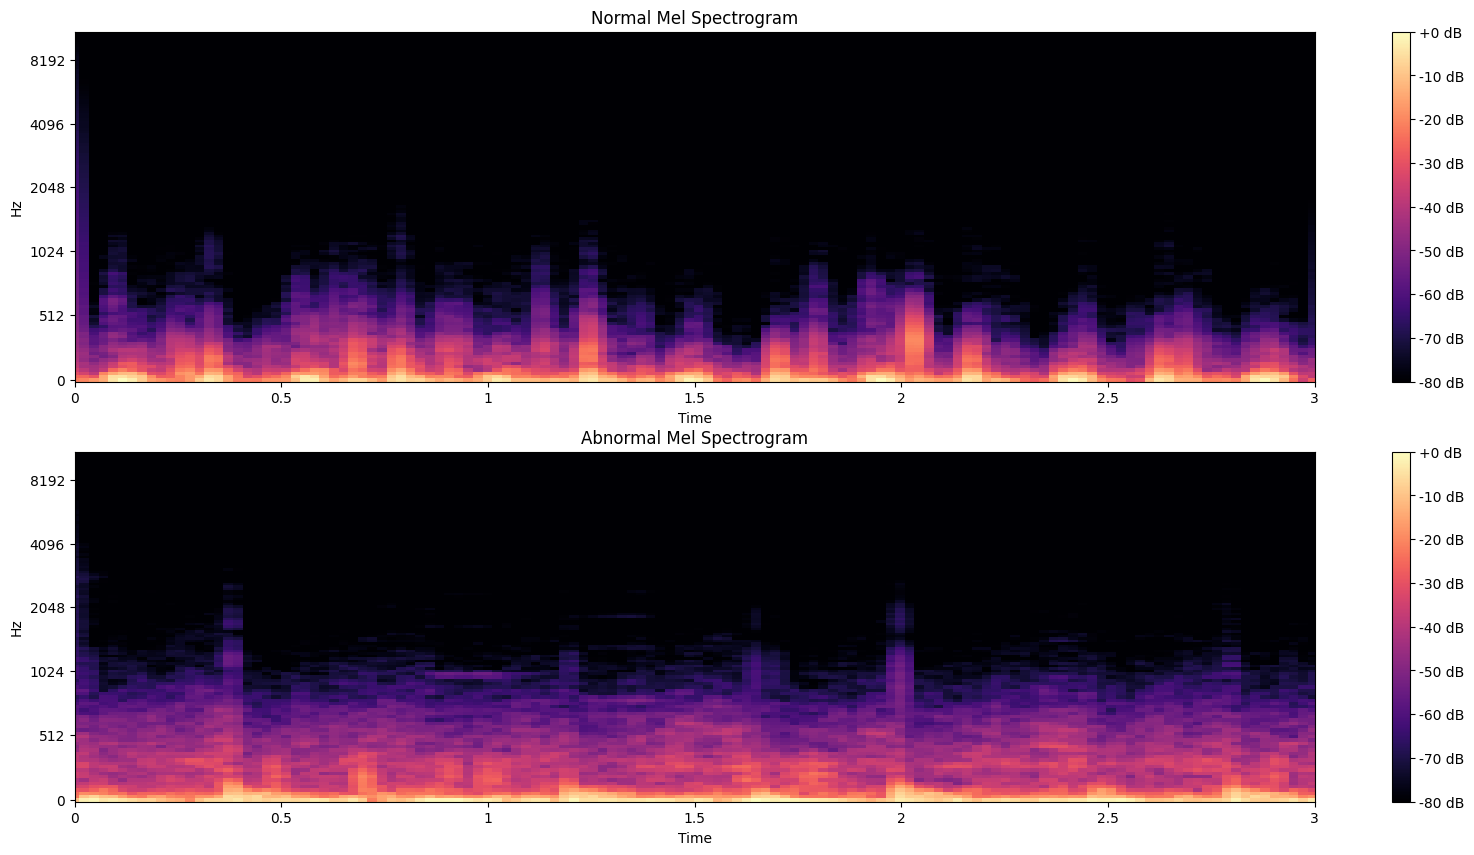

In [48]:
plt.figure(figsize=(20,10))

# Compute Mel Spectrogram for normal audio data
normal_S = librosa.feature.melspectrogram(y=normal_y, sr=normal_sr, n_fft=2048, hop_length=512, n_mels=128)
normal_S_DB = librosa.power_to_db(normal_S, ref=np.max)

# Plot normal Mel Spectrogram
plt.subplot(2, 1, 1)
librosa.display.specshow(normal_S_DB, sr=normal_sr, hop_length=512, x_axis='time', y_axis='mel')
plt.colorbar(format='%+2.0f dB')
plt.title("Normal Mel Spectrogram")
plt.xlim(0,3)

# Compute Mel Spectrogram for abnormal audio data
abnormal_S = librosa.feature.melspectrogram(y=abnormal_y, sr=abnormal_sr, n_fft=2048, hop_length=512, n_mels=128)
abnormal_S_DB = librosa.power_to_db(abnormal_S, ref=np.max)

# Plot abnormal Mel Spectrogram
plt.subplot(2, 1, 2)
librosa.display.specshow(abnormal_S_DB, sr=abnormal_sr, hop_length=512, x_axis='time', y_axis='mel')
plt.colorbar(format='%+2.0f dB')
plt.title("Abnormal Mel Spectrogram")
plt.xlim(0,3)

plt.show()


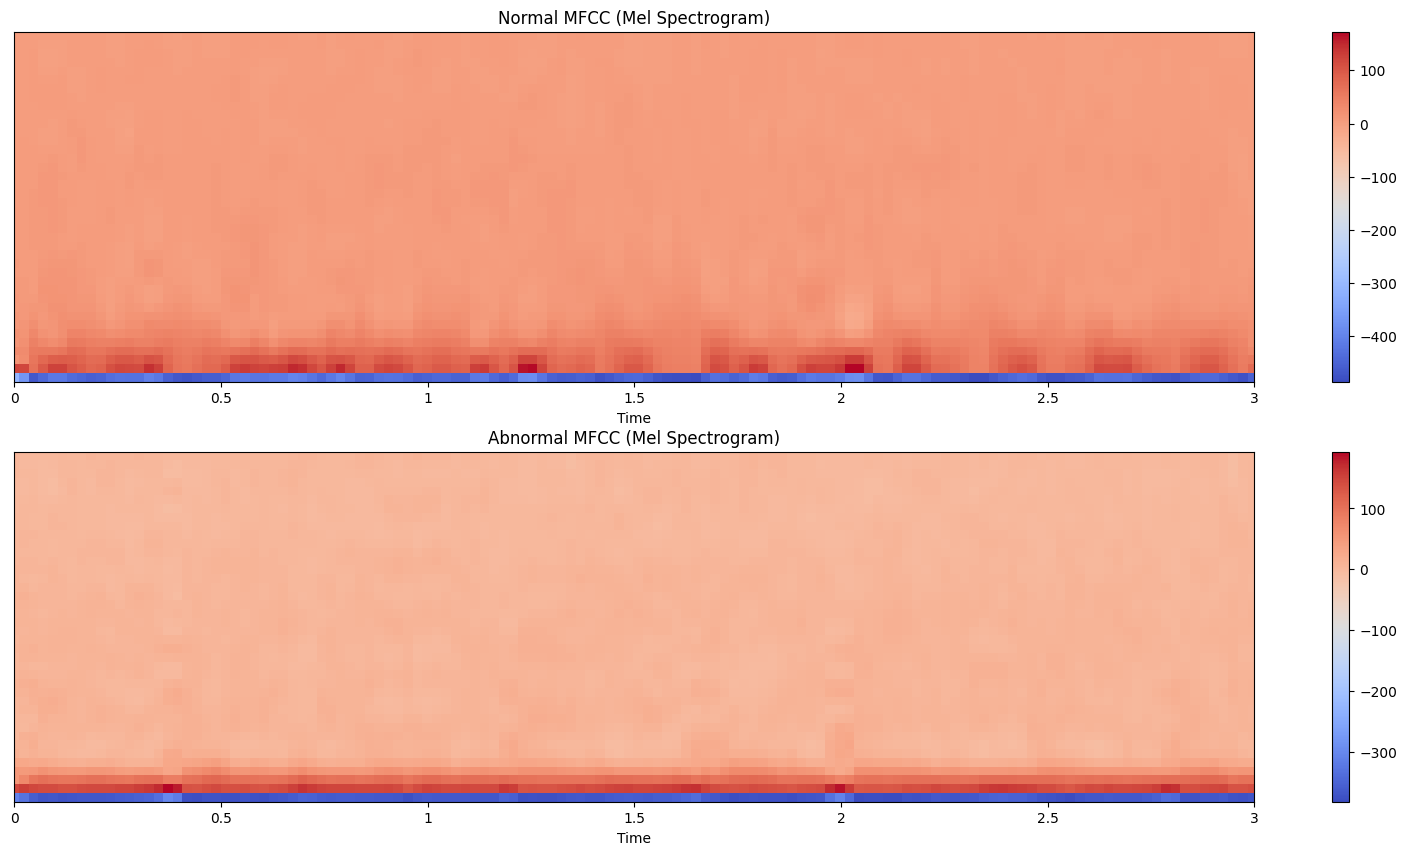

In [49]:
plt.figure(figsize=(20,10))

# Compute MFCC for normal audio data
normal_mfccs = librosa.feature.mfcc(y=normal_y, sr=normal_sr, n_mfcc=40)

# Plot normal MFCC
plt.subplot(2, 1, 1)
librosa.display.specshow(normal_mfccs, x_axis='time')
plt.colorbar()
plt.title("Normal MFCC (Mel Spectrogram)")
plt.xlim(0,3)

# Compute MFCC for abnormal audio data
abnormal_mfccs = librosa.feature.mfcc(y=abnormal_y, sr=abnormal_sr, n_mfcc=40)

# Plot abnormal MFCC
plt.subplot(2, 1, 2)
librosa.display.specshow(abnormal_mfccs, x_axis='time')
plt.colorbar()
plt.title("Abnormal MFCC (Mel Spectrogram)")
plt.xlim(0,3)

plt.show()

### Feature Extraction

In [17]:
def extract_features(audio_path,offset):
#     y, sr = librosa.load(audio_path, duration=3)
    y, sr = librosa.load(audio_path, offset=offset, duration=3)
#     y = librosa.util.normalize(y)
    
    S = librosa.feature.melspectrogram(y=y, sr=sr, n_fft=2048, 
                                   hop_length=512, 
                                   n_mels=128)
    mfccs = librosa.feature.mfcc(S=librosa.power_to_db(S), n_mfcc=40)

#     mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=40)
    return mfccs

In [18]:
x_train = []
x_test = []

for idx in tqdm(range(len(train))):
    x_train.append(extract_features(train.filename.iloc[idx],train.offset.iloc[idx]))

for idx in tqdm(range(len(test))):
    x_test.append(extract_features(test.filename.iloc[idx],test.offset.iloc[idx]))
    
x_test = np.asarray(x_test)
x_train = np.asarray(x_train)

print("X train:", x_train.shape)
print("X test:", x_test.shape)

  0%|          | 0/419 [00:00<?, ?it/s]

100%|██████████| 105/105 [00:03<00:00, 30.45it/s]

X train: (419, 40, 130)
X test: (105, 40, 130)


In [19]:
# Encode Labels
encoder = LabelEncoder()
encoder.fit(train.label)

y_train = encoder.transform(train.label)
y_test = encoder.transform(test.label)

# Compute class weights
class_weights = class_weight.compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)

# Convert the result to a dictionary
class_weights_dict = dict(enumerate(class_weights))

In [20]:
x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], x_train.shape[2], 1)
x_test = x_test.reshape(x_test.shape[0], x_test.shape[1], x_test.shape[2], 1)
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

print("X train:", x_train.shape)
print("Y train:", y_train.shape)
print("X test:", x_test.shape)
print("Y test:", y_test.shape)

X train: (419, 40, 130, 1)
Y train: (419, 2)
X test: (105, 40, 130, 1)
Y test: (105, 2)


### **Model Creation**

In [21]:
model = Sequential()
model.add(Conv2D(filters=16, kernel_size=2, input_shape=(x_train.shape[1],x_train.shape[2],x_train.shape[3]), activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.2))

model.add(Conv2D(filters=32, kernel_size=2, activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.2))

model.add(Conv2D(filters=64, kernel_size=2, activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.2))

model.add(Conv2D(filters=128, kernel_size=2, activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.5))
model.add(GlobalAveragePooling2D())

model.add(Dense(len(encoder.classes_), activation='softmax'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 39, 129, 16)       80        
                                                                 
 max_pooling2d (MaxPooling2D  (None, 19, 64, 16)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 19, 64, 16)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 18, 63, 32)        2080      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 9, 31, 32)        0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 9, 31, 32)         0

2024-05-15 12:49:03.568084: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1956] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [22]:
adam = keras.optimizers.Adam(learning_rate=0.001)
model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')

**Training of the model**

In [23]:
%%time
history = model.fit(x_train, y_train,
                    batch_size=128,
                    epochs=300,
                    validation_data=(x_test, y_test),
                    class_weight=class_weights_dict,  # Pass the dictionary here
                    shuffle=True)

Epoch 1/300
4/4 [==============================] - 2s 182ms/step - loss: 10.9772 - accuracy: 0.4749 - val_loss: 1.4234 - val_accuracy: 0.4095
Epoch 2/300
4/4 [==============================] - 0s 95ms/step - loss: 5.7462 - accuracy: 0.5251 - val_loss: 4.7465 - val_accuracy: 0.5905
Epoch 3/300
4/4 [==============================] - 0s 94ms/step - loss: 5.7600 - accuracy: 0.5680 - val_loss: 0.3390 - val_accuracy: 0.7905
Epoch 4/300
4/4 [==============================] - 0s 93ms/step - loss: 3.7489 - accuracy: 0.5943 - val_loss: 0.2005 - val_accuracy: 0.8857
Epoch 5/300
4/4 [==============================] - 0s 93ms/step - loss: 1.5295 - accuracy: 0.7279 - val_loss: 1.9171 - val_accuracy: 0.5905
Epoch 6/300
4/4 [==============================] - 0s 95ms/step - loss: 1.5861 - accuracy: 0.7399 - val_loss: 0.7776 - val_accuracy: 0.7238
Epoch 7/300
4/4 [==============================] - 0s 95ms/step - loss: 0.7328 - accuracy: 0.8329 - val_loss: 0.1561 - val_accuracy: 0.9143
Epoch 8/300
4/4 [=

Text(0.5, 1.0, 'Accuracy Curves')

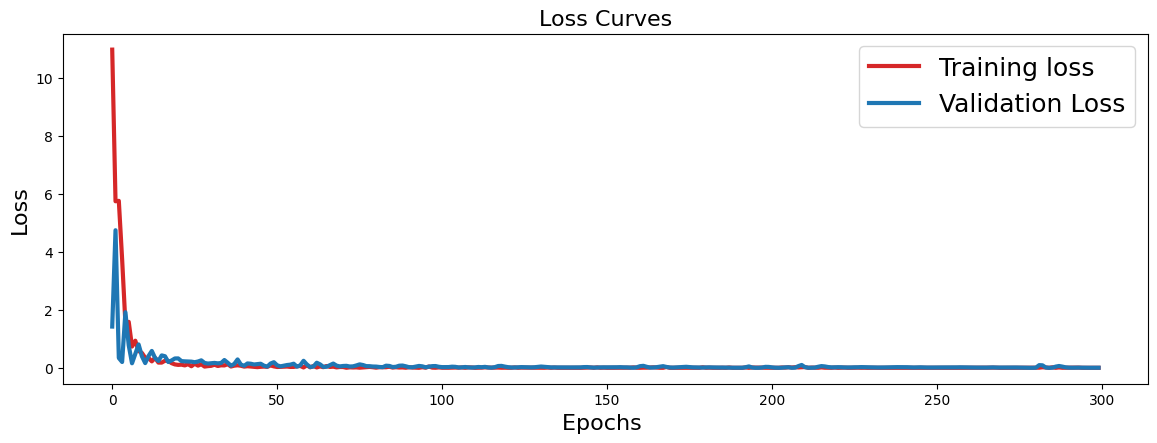

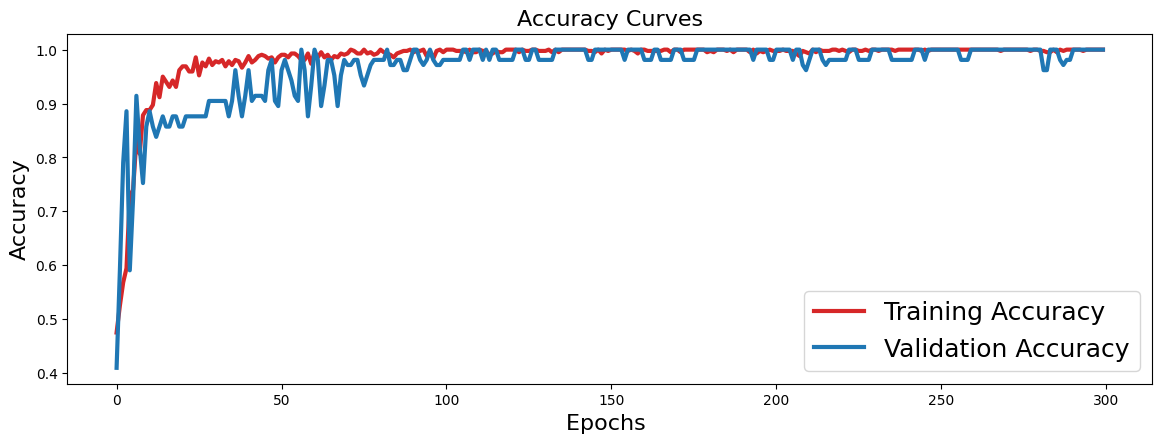

In [24]:
# Loss Curves
plt.figure(figsize=[14,10])
plt.subplot(211)
plt.plot(history.history['loss'],'#d62728',linewidth=3.0)
plt.plot(history.history['val_loss'],'#1f77b4',linewidth=3.0)
plt.legend(['Training loss', 'Validation Loss'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.title('Loss Curves',fontsize=16)
 
# Accuracy Curves
plt.figure(figsize=[14,10])
plt.subplot(212)
plt.plot(history.history['accuracy'],'#d62728',linewidth=3.0)
plt.plot(history.history['val_accuracy'],'#1f77b4',linewidth=3.0)
plt.legend(['Training Accuracy', 'Validation Accuracy'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Accuracy',fontsize=16)
plt.title('Accuracy Curves',fontsize=16)

In [25]:
scores = model.evaluate(x_test, y_test, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

1/4 [======>.......................] - ETA: 0s - loss: 0.0049 - accuracy: 1.0000

4/4 [==============================] - 0s 8ms/step - loss: 0.0031 - accuracy: 1.0000
Test loss: 0.0031481951009482145
Test accuracy: 1.0


In [26]:
predictions = model.predict(x_test, verbose=1)

y_true, y_pred = [],[]
classes = encoder.classes_
for idx, prediction in enumerate(predictions): 
    y_true.append(classes[np.argmax(y_test[idx])])
    y_pred.append(classes[np.argmax(prediction)])
    
print(classification_report(y_pred, y_true))

4/4 [==============================] - 0s 7ms/step
              precision    recall  f1-score   support

    abnormal       1.00      1.00      1.00        62
      normal       1.00      1.00      1.00        43

    accuracy                           1.00       105
   macro avg       1.00      1.00      1.00       105
weighted avg       1.00      1.00      1.00       105



In [27]:
model_name = "heartbeat_classifier (normalised).h5"
model.save(model_name)

## Classification of a random heartbeat 

In [28]:
from keras.models import load_model

# load model
model = load_model("heartbeat_classifier (normalised).h5")

# File to be classified
classify_file = "input/heartbeat_audio.wav"
x_test = []
x_test.append(extract_features(classify_file,0.5))
x_test = np.asarray(x_test)
x_test = x_test.reshape(x_test.shape[0], x_test.shape[1], x_test.shape[2], 1)
pred = model.predict(x_test,verbose=1)

print(pred)

1/1 [==============================] - 0s 97ms/step
[[9.999136e-01 8.640781e-05]]


In [29]:
# Get the class index with the highest probability
pred_class_index = np.argmax(pred)

# Map the class index to the actual class label using the encoder
classes = encoder.classes_
pred_class_label = classes[pred_class_index]

# Print the predicted class and confidence
if pred_class_label == "normal":
    print("Normal heartbeat")
    print("Confidence:", pred[0][pred_class_index])
else:
    print("Abnormal heartbeat")
    print("Confidence:", pred[0][pred_class_index])

Abnormal heartbeat
Confidence: 0.9999136


In [31]:
from scipy.io import wavfile

In [39]:
# Accuracy and loss percentages
accuracy_percent = pred[0][0] * 100
loss_percent = pred[0][1] * 100

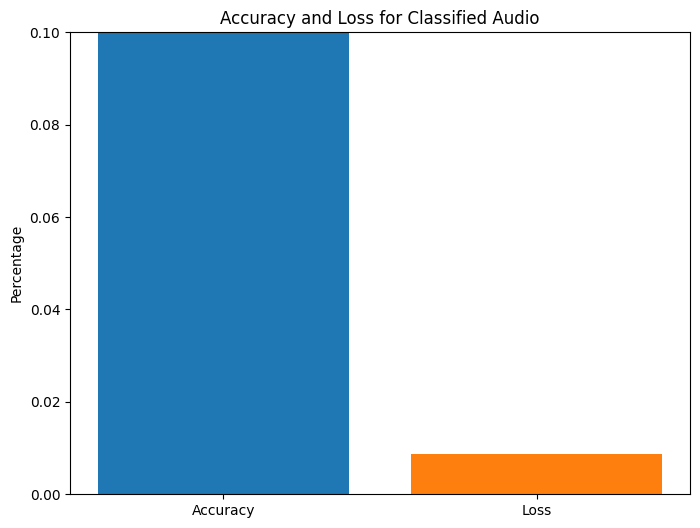

In [44]:
# Plot bar plot
labels = ['Accuracy', 'Loss']
values = [accuracy_percent, loss_percent]
colors = ['#1f77b4', '#ff7f0e']

plt.figure(figsize=(8, 6))
plt.bar(labels, values, color=colors)
plt.ylabel('Percentage')
plt.title('Accuracy and Loss for Classified Audio')
plt.ylim(0, 0.1)  # Set y-axis limit from 0 to 0.1
plt.show()


# the y-axis limit is reduced so that we can also show the loss bar in the bar plot

In [34]:
# Load and preprocess audio file
sr, audio_data = wavfile.read(classify_file)
audio_data = audio_data.astype(np.float32) / np.iinfo(np.int16).max  # Normalize audio data

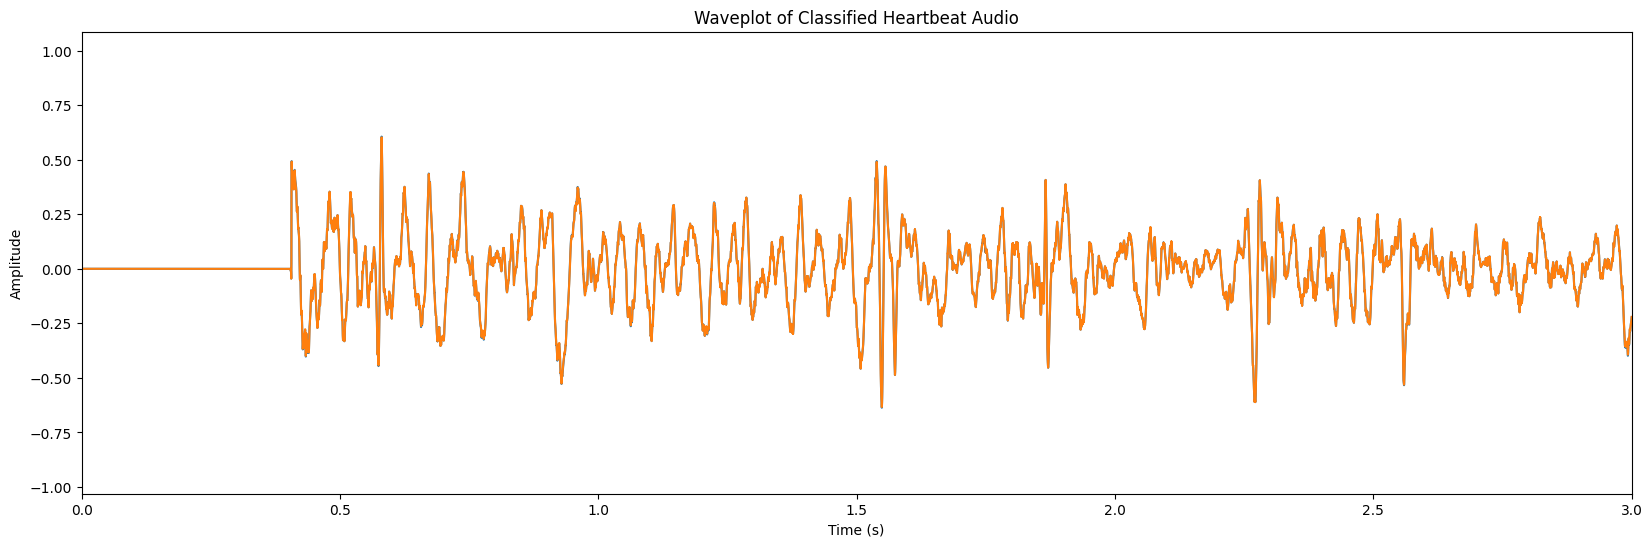

In [45]:
# Plot waveplot of the audio file
plt.figure(figsize=(20, 6))
plt.plot(np.arange(len(audio_data)) / sr, audio_data)
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.title('Waveplot of Classified Heartbeat Audio')
plt.xlim(0,3)
plt.show()